# HW8: The Bootstrap 

In this homework we will use the bootstrap to solve a financial problem: 

We will:

1. Review the properties of the t-student probability distribution and how we can use it to model the **fat tails** of stock market index returns.
2. We will work out how  estimate the uncertainty of index returns distributions using the bootstrap method.
3. (Optional) We will extend the example to perform  **robust regression**  between SPX and NDX indexes.

Given the distributional assumptions made and the size of the data samples, there are no readily available good analytic approximation to the standard deviation of parameter estimates. In this case the bootstrap the easiest method to generate those estimates.

Problems 1-4 are due for everyone. Bonus Problems 5 and 6 are optional. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
import scipy.optimize as opt

In [2]:
seed=57375
rng=np.random.default_rng(seed)

## Problem 1: Data

### Problem 1.1

Save files `index_returns_train.csv` and `index_returns_test.csv` to your local computer.

Both data sets contain the returns of the S&P 500 and Nasdaq equity indexes on different historical periods.


### Problem 1.2

Read the data from both files  into a `train_returns` DataFrame and a `test_returns` DataFrame.

In [3]:
data_dir="../../data/yfinance"

In [4]:
train_returns=pd.read_csv(f"{data_dir}/index_returns_train.csv")
train_returns.head()

,Date,SPX,NDX
0,2019-03-25,-0.000839,-0.001242
1,2019-03-26,0.007183,0.004673
2,2019-03-27,-0.004644,-0.005844
3,2019-03-28,0.003589,0.001680
4,2019-03-29,0.006734,0.007964


In [5]:
test_returns=pd.read_csv(f"{data_dir}/index_returns_test.csv")
test_returns.head()

,Date,SPX,NDX
0,2021-03-25,0.005240,-0.001435
1,2021-03-26,0.016631,0.015540
2,2021-03-29,-0.000868,-0.001031
3,2021-03-30,-0.003158,-0.005338
4,2021-03-31,0.003622,0.015113


### Problem 1.3

Inpect the `train_returns` dataset:

1. How may  columns do you have? And what are their names
2. How many rows of data do you have, what historical period does it cover?


In [6]:
# inspecting columns
len(train_returns.columns),train_returns.columns

(3, Index(['Date', 'SPX', 'NDX'], dtype='object'))

In [7]:
#inspecting rows
len(train_returns),train_returns["Date"].iloc[0],train_returns["Date"].iloc[-1]

(505, '2019-03-25', '2021-03-24')

### Problem 1.4

Inpect the `test_returns` dataset:

1. How may  columns do you have? And what are their names
2. How many rows of data do you have, what historical period does it cover?


In [8]:
# inspecting columns
len(test_returns.columns),test_returns.columns

(3, Index(['Date', 'SPX', 'NDX'], dtype='object'))

In [9]:
#inspecting rows
len(test_returns),test_returns["Date"].iloc[0],test_returns["Date"].iloc[-1]

(504, '2021-03-25', '2023-03-24')

### Problem 1.5

Define `numpy` arrays:

1. `SPX` containing the returns of S & P 500  during the training period.
2.  `NDX` containing the returns of Nasdaq on the training period.
3.  `SPX_test` containing the returns of S & P 500 on the test period.
4.  `NDX_test` containing the returns of Nasdaq on the test period.
    
[HINT] you can use the DataFrame function [to_numpy()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html#pandas.DataFrame.to_numpy) tp extract data from a DataFrame.

In [10]:
SPX=train_returns["SPX"].to_numpy()
NDX=train_returns["NDX"].to_numpy()
SPX.shape,NDX.shape

((505,), (505,))

In [11]:
SPX_test=test_returns["SPX"].to_numpy()
NDX_test=test_returns["NDX"].to_numpy()
SPX_test.shape,NDX_test.shape

((504,), (504,))

## Problem 2: Student-T distribution

Equity index returns exhibit **fat tails**: large deviations from the mean are move likely than what would be predicted by a Gaussian distribution.

One possible ways to model fat tail distributions is using a **Student-T** distribution. 

### Normalized Student-T  Distribution

The (normalized) **student's t** distribution
$$
    X \sim t_n
$$
is the distribution of the ratio of a normaly distributed random variable  and the square root of a Chi-squared distributed independent random variable

$$
    t_n \sim \frac{Z}{S} \ \ \ \ \text{where }\ Z\sim \mathcal{N}(0,1)\ \ \ \text{and }\ S^2 \sim \frac{\chi_n^2}{n}
$$
    
the pdf of the $t_n$ distribution is given by

$$
    p(x;n) = \frac{\Gamma\left(\frac{n+1}{2}\right)}{\sqrt{n\pi}\Gamma\left(\frac{n}{2}\right)}\left(1 + \frac{x^2}{n} \right)^{-\frac{n+1}{2}}\ \ \ \ \text{where }\ -\infty < x < \infty 
$$

Student's $t_n$ distribution appears naturally when performing **hypothesis tests** about the means of Gaussian random variables from finite samples.



The the key properties of  (normalized) Student's $t_n$ distribution are:

1. It is symmetric around its mean.
2. $n$ is called the **degrees of freedom** of the distribution.
3. $t_n$  is well defined for $n>1$
3. As $n$ becomes large Student's $t_n$ distribution approaches a normal distribution $\mathcal{N}(0,1)$.

Text(0, 0.5, 'pdf($t$)')

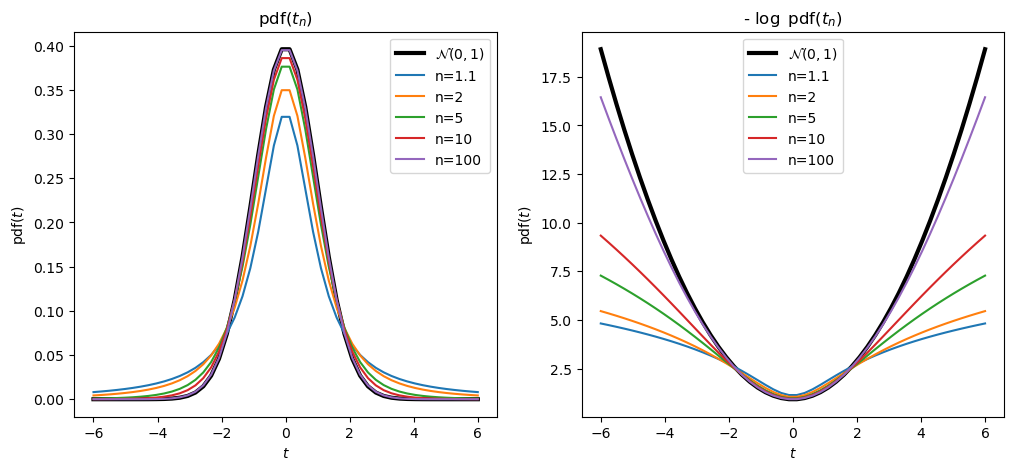

In [12]:
fig=plt.figure(figsize=(12,5))

x=np.linspace(-6,6)

plt.subplot(121)
plt.title(r"pdf($t_n$)")

dist_normal=stats.norm(0,1)
plt.plot(x,dist_normal.pdf(x),color="k",linewidth=3,label=r"$\mathcal{N}(0,1)$")
ns=[1.1,2,5,10,100]
for n in ns:
    dist=stats.t(df=n)
    plt.plot(x,dist.pdf(x),label=f"n={n}")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("pdf($t$)")

plt.subplot(122)
plt.title(r"- $\log$ pdf($t_n$)")

dist_normal=stats.norm(0,1)
plt.plot(x,-dist_normal.logpdf(x),color="k",linewidth=3,label=r"$\mathcal{N}(0,1)$")
ns=[1.1,2,5,10,100]
for n in ns:
    dist=stats.t(df=n)
    plt.plot(x,-dist.logpdf(x),label=f"n={n}")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("pdf($t$)")

### Distribution of Stock Returns

`scipy.stats` defines a [t distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) with three parameters:
1. `df` is the number of degrees of freedom (our $n$ parameter), $1 < n$
2. `loc` the maximum of the distribution (our $\mu$ parameter), $-\infty < \mu, < \infty $ 
3. `scale` the scale of the distribution (our $\sigma$ parameter), $ 0 < \sigma$

so that

$$
    \text{stats.t}(\text{df}=n,\text{loc}=\mu,\text{scale}=\sigma) \sim \mu + \sigma\, t_n
$$

where $t_n$ is the normalized Studen-t $t$ distribution we defined above.

We would like to assume  NDX returns follow a Student's-T distribution with parameters $n,\mu,\sigma$:

$$
    \text{NDX} \sim \text{stats.t}(\text{df}=n,\text{loc}=\mu,\text{scale}=\sigma)
$$

We will define a parameter vector $\heta=(\theta_1,\theta_2,\theta_3) as follows:

\begin{align*}
     \theta_1 & = \log ( n -1)    \\
     \theta_2 & = \mu \\
     \theta_3 & = \log \sigma
\end{align*}

so that, given any vector $\theta$ we can reconstruct the  distribution parameters as:

\begin{align*}
    n &= 1 + e^{\theta_1}  &( 1<n) \\
    \mu &= \theta_2  \\
    \sigma &= e^{\theta_2}   &( 0<\sigma) \\
\end{align*}

### Problem 2.1

Given parameter guess
1. $n_\text{guess}=3$
2. $\mu_\text{guess}=0$
3. $\sigma_\text{guess}=0.001$

Define a `numpy` array containing  the   3-dimentional vector parameter vector $\theta=(\theta_1,\theta_2,\theta_3)$ 

In [13]:
n_guess = 3
mu_guess = 0
sigma_guess = 0.001

In [14]:
theta_guess= np.array( [
    np.log(n_guess-1), 
    mu_guess, 
    np.log(sigma_guess)
])
theta_guess

array([ 0.69314718,  0.        , -6.90775528])

### Problem 2.2

Define the student's distribution negative log likelihood loss,  defined as:

$$
    L(\theta; X) = -\sum_{i=1}^N \log P_\theta (x_i)
$$

where $P_\theta$ is the t-student's distribution pdf as defined by the 3 parameters $\theta$ 

[HINTS] 
1. Scipy's [student's t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) distribution implements 
a `logpdf(x)` method returning the log probability density of observation $x$. You do not need to implement any complicated formulas.
2. To define the distribution you can use the constructor
    dist=student.t(df=n,loc=mu,scale=sigma)
3.  You must use the formulas defined at the begining of problem 3 to transform from $\theta$ to $n,\mu,\sigma$

In [15]:
def student_loss(theta,X):
    pass # write your implementation here

In [16]:
def student_loss(theta,X):
    n=1 + np.exp(theta[0])
    mu=theta[1]
    sigma=np.exp(theta[2])
    dist=stats.t(df=n,loc=mu,scale=sigma)
    return - np.sum( dist.logpdf(X))

### Problem 2.3

Evaluate the student's distribution loss using our $\theta_\text{guess}$ parameters and the `NDX` returns in the training period.

In [17]:
student_loss(theta_guess,NDX)

125.53852462983883

### Problem 2.4

Use [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to find the
parameters $\theta_\text{ML}$$ that minimze the Student's-T loss.

[HINTS]
1. [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) minimizes 
a function $f(x)$ over aparameter $x$, in our case $x$ is $\theta$.
2. The relevant part of the signature of scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)
is
    fit=scipy.optimize.miminize(loss,theta_guess,args=(<other parameters to loss>))
3 The `fit` object contains a variable `fit.x` with the parameters that minimize $f(x)$.

In [18]:
fit=opt.minimize(student_loss,theta_guess,args=(NDX,))
theta_ML=fit.x
theta_ML

array([ 2.60246675e-01,  2.53058931e-03, -4.65692972e+00])

### Problem 2.5

compute the Student's T loss with the optimal parameters $\theta_\text{ML}$ and verify that is smaller that the loss with our initial guess $\theta_{\text{guess}}$:

In [19]:
student_loss(theta_ML,NDX)

-1398.6364125750142

### Problem 2.6 

Transform $\theta_{\text{ML}}$ into $n_{\text{ML}}$, $\mu_{\text{ML}}$, $\sigma_{\text{ML}}$:

In [20]:
n_ML=1+np.exp(theta_ML[0])
mu_ML=theta_ML[1]
sigma_ML=np.exp(theta_ML[2])
n_ML,mu_ML,sigma_ML

(2.2972500466794825, 0.0025305893060239754, 0.009495571756087956)

### Problem 2.7

Compare your parameters to the result of [ scipy.stats.t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html)
`fit(X)` method

In [21]:
stats.t.fit(NDX)

(2.297281213237216, 0.0025306482540340385, 0.009495590701749265)

### Problem 2.8

Using the constructor `scipy.stats.t(df,loc,scale)` define a [ scipy.stats.t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) distribution with
the maximum likelihood estimate of the parameter $n,\mu,\sigma$:

In [22]:
dist_ML=stats.t(df=n_ML,loc=mu_ML,scale=sigma_ML)

### Problem 2.9 

1. Plot a histogram of the historical `NDX` returns
2. Add a plot of Student's-T maximum likelihood distribution pdf.
3. Add a plot of the Gaussian   maximum likelihood estimate pdf.
4. Which distribution fits better, Student's-T or Gaussian?

[HINTS]
1. use the argument `density=True` to [matplotlib.pyplot.hist](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.hist.html)
   so that the histogram is normalized as a pdf.
2. The default number of bins in `hist()` is too small, use a larger number of bins i.e `bins=np.linspace(-0.1,0.1,25)`.
2. You can use the method `fit()` of [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)
   to find the best fitting Gaussian (but you can also compute mean and standard deviation by hand if you prefer)

(-0.1, 0.1)

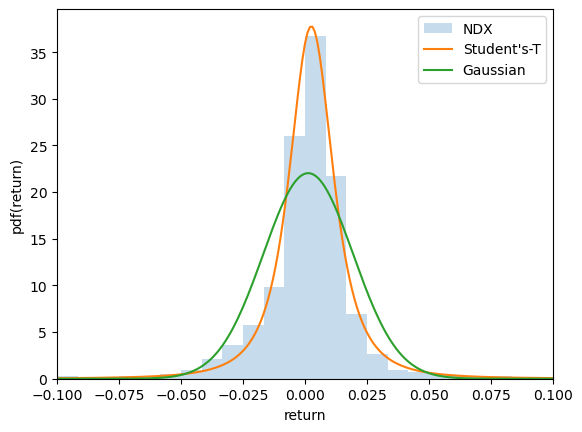

In [23]:
plt.hist(NDX,density=True,bins=np.linspace(-0.1,0.1,25),label="NDX",alpha=0.25)
x=np.linspace(-0.1,0.1,201)
plt.plot(x,dist_ML.pdf(x),label="Student's-T")
mu,sigma=stats.norm.fit(NDX)
dist_norm=stats.norm(loc=mu,scale=sigma)
plt.plot(x,dist_norm.pdf(x),label="Gaussian")
plt.legend()
plt.xlabel("return")
plt.ylabel("pdf(return)")
plt.xlim(-0.1,0.1)

## Problem 3:  Parametric Bootstrap

### Problem 3.1

Use the maximum likelihood distribution you just defined to draw $N$ random samples ($N$ is the number of samples on the `NDX` dataset)

[HINTS] You can use the method `rvs(size=N)` of the [ scipy.stats.t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html)  distribution.

In [24]:
N=len(NDX)
samples = dist_ML.rvs(size=N)
samples.shape

(505,)

### Problem 3.2

Plot the discribution of the samples just generated (like you did in problem 1.7) and compare it the the plot o the pdf of the maximum likelihood distribution you used to generate the samples.

(-0.1, 0.1)

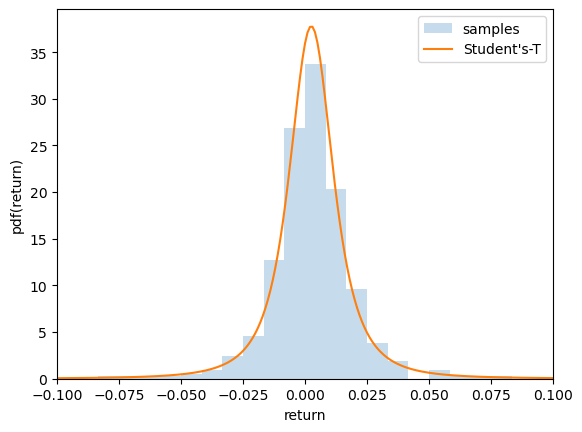

In [25]:
plt.hist(samples,density=True,bins=np.linspace(-0.1,0.1,25),label="samples",alpha=0.25)
x=np.linspace(-0.1,0.1,201)
plt.plot(x,dist_ML.pdf(x),label="Student's-T")
plt.legend()
plt.xlabel("return")
plt.ylabel("pdf(return)")
plt.xlim(-0.1,0.1)

In [26]:
samples[:10]

array([-0.01254201,  0.00411649,  0.01273854,  0.02149007,  0.00549382,
        0.0045494 ,  0.00287471, -0.01330387, -0.01593455, -0.00227039])

### Problem 3.3

Implement **parametric bootstrap** with $R=1,000$ repeats:

1. Define an array  `thetas` of size $(R,3)$
2. For $r=1,2,\dots,R$ repeat
    1. Generate a random sample of $N$ points from the maximum likelihood distribution.
    2. Find the maximum likelihood estimate $\theta_r$ of the sampled  data.
3. Return the  array `thetas` of sampled  $\theta_r$ estimates

In [27]:
def parametric_bootstrap(loss,Definetheta_guess, dist_ML, N,R):
    pass # write your implementation here

In [28]:
def parametric_bootstrap(loss,theta_guess, dist_ML, N,R):
    thetas=np.empty((R,len(theta_guess)))
    for r in range(R):
        samples=dist_ML.rvs(size=N,random_state=rng)
        # samples=mu_ML+sigma_ML*rng.standard_t(df=nu_ML,size=N) also works
        fit=opt.minimize(loss,theta_guess,args=(samples,))
        thetas[r]=fit.x
    return thetas
    

In [29]:
R = 1_000

In [30]:
thetas_p=parametric_bootstrap(student_loss,theta_guess,dist_ML,N,R)
thetas_p.shape

(1000, 3)

### Problem 3.4

Compute the mean and standard deviation of $\theta_1,\theta_2,\theta_3$

In [31]:
thetas_p.mean(axis=0)

array([ 2.66390328e-01,  2.52207913e-03, -4.66045977e+00])

In [32]:
thetas_p.std(axis=0)

array([0.23053006, 0.00051952, 0.06228228])

### Problem 3.5

1. Plot the histogram of distributions of parametric bootstrap parameterers for  $\theta_1,\theta_2$ and $\theta_3$.
2. Compare it to a plot of the best fitting Gaussian approximation to the distribution of the bootstrap parameters.
3. Clearly highlight in the graph the 

Text(0, 0.5, 'pdf($\\theta_3$)')

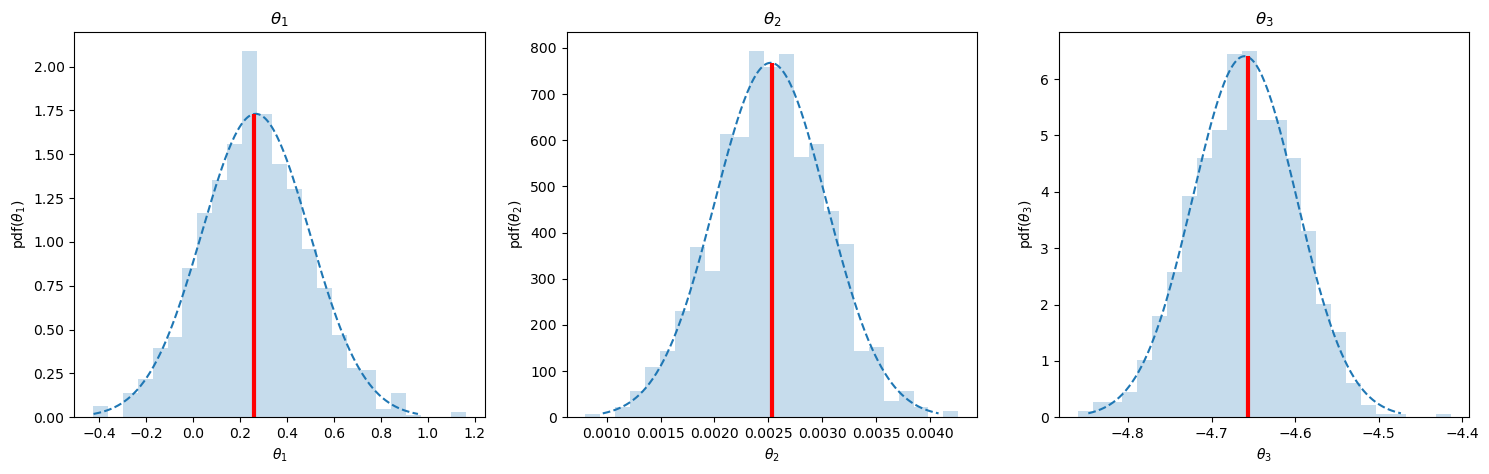

In [33]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.title(r"$\theta_1$")
dist1=stats.norm(thetas_p[:,0].mean(),thetas_p[:,0].std())
x=np.linspace(dist1.mean()-3*dist1.std(),dist1.mean()+3*dist1.std(),201)
p=plt.plot(x,dist1.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(thetas_p[:,0],density=True,bins=25,alpha=0.25,color=c)
plt.vlines(theta_ML[0],0,np.max(dist1.pdf(x)),color="red",linewidth=3)
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"pdf($\theta_1$)")


plt.subplot(132)
plt.title(r"$\theta_2$")
dist1=stats.norm(thetas_p[:,1].mean(),thetas_p[:,1].std())
x=np.linspace(dist1.mean()-3*dist1.std(),dist1.mean()+3*dist1.std(),201)
p=plt.plot(x,dist1.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(thetas_p[:,1],density=True,bins=25,alpha=0.25,color=c)
plt.vlines(theta_ML[1],0,np.max(dist1.pdf(x)),color="red",linewidth=3)
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"pdf($\theta_2$)")


plt.subplot(133)
plt.title(r"$\theta_3$")
dist1=stats.norm(thetas_p[:,2].mean(),thetas_p[:,2].std())
x=np.linspace(dist1.mean()-3*dist1.std(),dist1.mean()+3*dist1.std(),201)
p=plt.plot(x,dist1.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(thetas_p[:,2],density=True,bins=25,alpha=0.25,color=c)
plt.vlines(theta_ML[2],0,np.max(dist1.pdf(x)),color="red",linewidth=3)
plt.xlabel(r"$\theta_3$")
plt.ylabel(r"pdf($\theta_3$)")

### Problem 3.6

Generate three arrays of size $R$  `ns_p`, `mus_p` and `sigmas_p` with the parameters $n,\mu,\sigma$ of the parametric bootstrap samples:

[HINTS] Use the formulas from Problem 1 to transform from $\theta_1,\theta_2,\theta_3$ to $n,\mu,\sigma$.

In [34]:
ns_p= 1 + np.exp(thetas_p[:,0])
mus_p = thetas_p[:,1]
sigmas_p=np.exp(thetas_p[:,2])

### Problem 3.7

Compute the mean and stardard deviation of the parametric bootstrap samples of $n$, $\mu$ and $\sigma$:

In [35]:
print("n = ",ns_p.mean(),"+/-",ns_p.std())
print("mu = ",mus_p.mean(),"+/-",mus_p.std())
print("sigma = ",sigmas_p.mean(),"+/-",sigmas_p.std())

n =  2.3408825345661826 +/- 0.32091855514767753
mu =  0.0025220791319096377 +/- 0.0005195213669029462
sigma =  0.009480449606128444 +/- 0.0005895250722647461


### Problem 3.8

1. Plot a histogram of the  distributions of the parametric bootstrap samples of $n$, $\mu$ and $\sigma$
2. Superimpose the best Gaussian fit to the bootstrap distribution of each parameter.
3. Clearly highlight in the histogram the maximum likelihood estimated of the parameter that you used to generate the distribution.

Text(0, 0.5, 'pdf($\\mu$)')

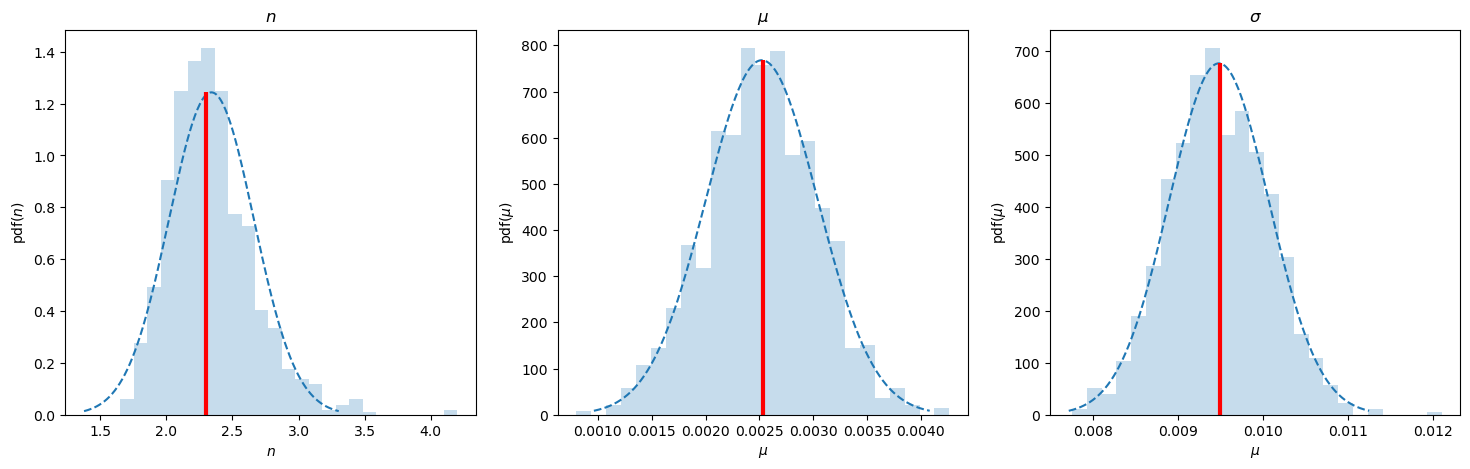

In [36]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.title(r"$n$")
dist1=stats.norm(ns_p.mean(),ns_p.std())
x=np.linspace(dist1.mean()-3*dist1.std(),dist1.mean()+3*dist1.std(),201)
p=plt.plot(x,dist1.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(ns_p,density=True,bins=25,alpha=0.25,color=c)
plt.vlines(n_ML,0,np.max(dist1.pdf(x)),color="red",linewidth=3)
plt.xlabel(r"$n$")
plt.ylabel(r"pdf($n$)")

plt.subplot(132)
plt.title(r"$\mu$")
dist1=stats.norm(mus_p.mean(),mus_p.std())
x=np.linspace(dist1.mean()-3*dist1.std(),dist1.mean()+3*dist1.std(),201)
p=plt.plot(x,dist1.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(mus_p,density=True,bins=25,alpha=0.25,color=c)
plt.vlines(mu_ML,0,np.max(dist1.pdf(x)),color="red",linewidth=3)
plt.xlabel(r"$\mu$")
plt.ylabel(r"pdf($\mu$)")


plt.subplot(133)
plt.title(r"$\sigma$")
dist1=stats.norm(sigmas_p.mean(),sigmas_p.std())
x=np.linspace(dist1.mean()-3*dist1.std(),dist1.mean()+3*dist1.std(),201)
p=plt.plot(x,dist1.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(sigmas_p,density=True,bins=25,alpha=0.25,color=c)
plt.vlines(sigma_ML,0,np.max(dist1.pdf(x)),color="red",linewidth=3)
plt.xlabel(r"$\mu$")
plt.ylabel(r"pdf($\mu$)")



## Problem 4: Non-Parametric Bootstrap

### Problem 4.1

Generate a sample of $N$ observation by sampling with replacement from the `NDX`  returns of the training period.

[HINTS] Use [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) function of the random number generator.

In [37]:
samples=rng.choice(NDX,size=N,replace=True)
samples.shape

(505,)

### Problem 4.2

Make a plot comparing the histogram of non-parametric bootstrap samples to the pdf of the maximum likelihood distribution.

Text(0, 0.5, 'pdf(NDX)')

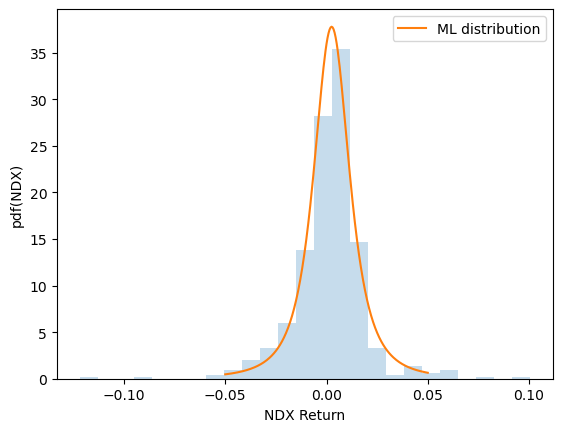

In [38]:
plt.hist(samples,density=True,alpha=0.25,bins=25)
x=np.linspace(-0.05,0.05,201)
plt.plot(x,dist_ML.pdf(x),label="ML distribution")
plt.legend()
plt.xlabel("NDX Return")
plt.ylabel("pdf(NDX)")

### Problem 4.3

Implement the **non-parametric bootstrap** with $R=1,000$ repeats:

1. Define an array  `thetas` of size $(R,3)$
2. For $r=1,2,\dots,R$ repeat
    1. Chose  with replacement   $N$  random samples  from the `NDX` training returns .
    2. Find the maximum likelihood estimate $\theta_r$ of the sampled  data.
3. Return the  array `thetas` of sampled  $\theta_r$ estimates

In [39]:
def non_parametric_bootstrap(loss,theta_guess,X,R):
    pass # write your implementation here

In [40]:
def non_parametric_bootstrap(loss,theta_guess,X,R):
    N=len(X)
    thetas=np.empty((R,len(theta_guess)))
    for r in range(R):
        samples=rng.choice(X,size=N,replace=True)
        fit=opt.minimize(loss,theta_guess,args=(samples,))
        thetas[r]=fit.x
    return thetas

In [41]:
thetas_np=non_parametric_bootstrap(student_loss,theta_ML,NDX,R)
thetas_np.shape

(1000, 3)

### Problem 4.4 

Compare the mean and standard deviation of the parametric and non-parametric bootstrap distribution of samples

In [42]:
print("    Parametric Mean",thetas_p.mean(axis=0))
print("Non-Parametric Mean",thetas_np.mean(axis=0))


    Parametric Mean [ 2.66390328e-01  2.52207913e-03 -4.66045977e+00]
Non-Parametric Mean [ 2.76248595e-01  2.48581529e-03 -4.65786809e+00]


In [43]:
# standard deviations are close, but not identical
print("    Parametric Std",thetas_p.std(axis=0))
print("Non-Parametric Std",thetas_np.std(axis=0))


    Parametric Std [0.23053006 0.00051952 0.06228228]
Non-Parametric Std [0.21456    0.00052983 0.06445389]


## Bonus Problem 5: Robust (Student-T) Regresion

The returns of `SPX` and `NDX` are highly correlated, so we would like to define a regression model for `NDX` based on the 
following equation:

$$
        Y = \alpha + \beta\, X  + \sigma \, t_{n}
$$

where $Y$ are the daily returns of `NDX`, `X` are the daily returns of `SPX`, and $t_{n}$ is a normalized **Student-T distribution with $n$ degrees of freedom.

This is an example of a **robust regression** model as large values of the residual (error term) are more likely with a  $t_n$ distribution than the **ordinary regression** Gaussian assumption.

This model has 4 parameters $\theta=(\theta_1,\theta_2,\theta_3,\theta_4)$ we need to estimate

\begin{align*}
    \alpha &= \theta_1 \\
    \beta  &= \theta_2 \\
     n     &= 1 + e^{\theta_3} \\
     \sigma&= e^ {\theta_4} 
 \end{align*}
    
    

### Problem 5.1

Implement the student_regression log likelihood loss.

[HINTS] The difference $\text{d}Y=Y - \alpha - \beta \, X$ has a `student.t(df=n,loc=0,scale=sigma)` distribution 

In [44]:
def student_regression_loss(theta,X,Y):
    pass

In [45]:
def student_regression_loss(theta,X,Y):
    alpha=theta[0]
    beta=theta[1]
    n = 1 + np.exp(theta[2])
    sigma= np.exp(theta[3])
    dY= Y - alpha -beta* X
    dist=stats.t(df=n,loc=0,scale=sigma)
    return -np.sum(dist.logpdf(dY))

### Problem 5.2

Make the initial guess:
\begin{align*}
    \alpha_{\text{guess}} &= 0 \\
    \beta_{\text{guess}} &= 1 \\
    n_{\text{guess}}    &= 5 \\
    \sigma_{\text{guess}} &=  0.01 \\
\end{align*}

and evaluate the regression loss give that guess:

In [46]:
alpha_guess=0
beta_guess=1
n_guess=5
sigma_guess=0.01
theta_guess=np.array([alpha_guess,
                      beta_guess,
                      np.log(n_guess)-1,
                      np.log(sigma_guess)
                     ])
theta_guess

array([ 0.        ,  1.        ,  0.60943791, -4.60517019])

In [47]:
student_regression_loss(theta_guess,SPX,NDX)

-1700.4321977829443

###  Problem 5.3

Using the `NDX` and `SPX` returns over the training period, find the maximum likelihood estimate $\hat{\theta}_{\text{ML}}$ of the robust regression model.

Show clearly the maximum likelihood estimates of $\alpha,\beta,n$ and $\sigma$

In [48]:
fit=opt.minimize(student_regression_loss,theta_guess,args=(SPX,NDX))
reg_theta_ML=fit.x
reg_theta_ML

array([ 6.33564581e-04,  1.05417602e+00,  6.17924163e-01, -5.46154902e+00])

In [49]:
reg_alpha_ML=reg_theta_ML[0]
reg_beta_ML=reg_theta_ML[1]
reg_n_ML=1+np.exp(reg_theta_ML[2])
reg_sigma_ML=np.exp(reg_theta_ML[3])
reg_alpha_ML,reg_beta_ML,reg_n_ML,reg_sigma_ML

(0.0006335645814909453,
 1.0541760187265554,
 2.8550732118681017,
 0.004246972018238065)

### Problem 5.4

Compute the maximum likelihood loss for the parameter estimate and verify that it is lower than our initial guess.

In [50]:
student_regression_loss(reg_theta_ML,SPX,NDX)

-1852.9888688937085

### Problem 5.5

Make a scatter plot of $X$ the `SPX` returns against $Y$ the  `NDX` returns and supper impose the predicted regression line $\hat{Y} = \alpha_{\text{ML}} + \beta_{\text{ML}}\, X$

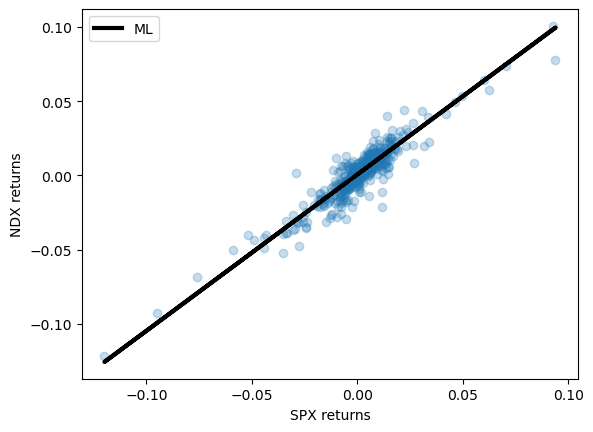

In [51]:
plt.scatter(SPX,NDX,alpha=0.25)
plt.plot(SPX,reg_alpha_ML+reg_beta_ML * SPX,linewidth=3,color="k",label="ML")
plt.xlabel("SPX returns")
plt.ylabel("NDX returns")
plt.legend()

### Problem 5.6

Generate $R$=1,000 samples bootstrap (parametric or non-parametric, you choose) samples of $\alpha,\beta,n$ and $\sigma$:


In [52]:
N=len(NDX)
reg_thetas=np.empty((R,len(theta_guess)))
for r in range(R):
    idx=rng.choice(N,N)
    X=SPX[idx]
    Y=NDX[idx]
    fit=opt.minimize(student_regression_loss,reg_theta_ML,args=(X,Y))
    reg_thetas[r]=fit.x
reg_thetas.shape

(1000, 4)

### Problem 5.7


1. Plot a histogram of the  distributions of  bootstrap samples of $\alpha$,$\beta$, $\sigma$ and $n$.
2. Superimpose the best Gaussian fit to the bootstrap distribution of each parameter.
3. Clearly highlight in the histogram the maximum likelihood estimated of the parameter that you used to generate the distribution.

In [53]:
reg_alphas=reg_thetas[:,0]
reg_betas=reg_thetas[:,1]
reg_ns = 1 + np.exp(reg_thetas[:,2])
reg_sigmas=np.exp(reg_thetas[:,3])

Text(0, 0.5, 'pdf($\\sigma$)')

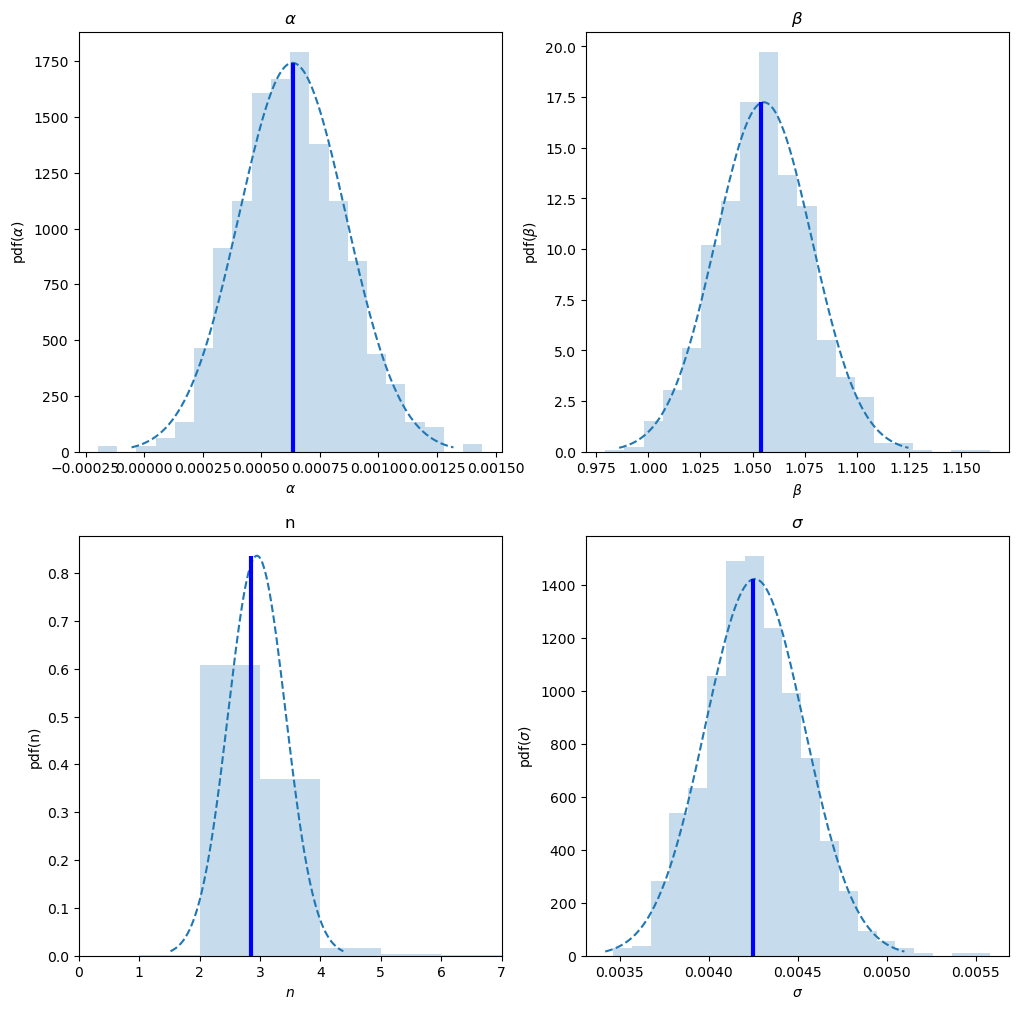

In [54]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.title(r"$\alpha$")
dist1=stats.norm(reg_alphas.mean(),reg_alphas.std())
x=np.linspace(dist1.mean()-3*dist1.std(),dist1.mean()+3*dist1.std(),201)
p=plt.plot(x,dist1.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(reg_alphas,density=True,bins=20,alpha=0.25,color=c)
plt.vlines(reg_alpha_ML,0,np.max(dist1.pdf(x)),color="blue",linewidth=3)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"pdf($\alpha$)")

plt.subplot(222)
plt.title(r"$\beta$")
dist2=stats.norm(reg_betas.mean(),reg_betas.std())
x=np.linspace(dist2.mean()-3*dist2.std(),dist2.mean()+3*dist2.std(),201)
p=plt.plot(x,dist2.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(reg_betas,density=True,bins=20,alpha=0.25,color=c)
plt.vlines(reg_beta_ML,0,np.max(dist2.pdf(x)),color="blue",linewidth=3)
plt.xlabel(r"$\beta$")
plt.ylabel(r"pdf($\beta$)")

plt.subplot(223)
plt.title(r"n")
dist2=stats.norm(reg_ns.mean(),reg_ns.std())
x=np.linspace(dist2.mean()-3*dist2.std(),dist2.mean()+3*dist2.std(),201)
p=plt.plot(x,dist2.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(reg_ns,density=True,bins=np.arange(25),alpha=0.25,color=c)
plt.vlines(reg_n_ML,0,np.max(dist2.pdf(x)),color="blue",linewidth=3)
plt.xlabel(r"$n$")
plt.ylabel(r"pdf(n)")
plt.xlim(0,7)

plt.subplot(224)
plt.title(r"$\sigma$")
dist3=stats.norm(reg_sigmas.mean(),reg_sigmas.std())
x=np.linspace(dist3.mean()-3*dist3.std(),dist3.mean()+3*dist3.std(),201)
p=plt.plot(x,dist3.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(reg_sigmas,density=True,bins=20,alpha=0.25,color=c)
plt.vlines(reg_sigma_ML,0,np.max(dist3.pdf(x)),color="blue",linewidth=3)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"pdf($\sigma$)")


## Bonus Problem 6: Test estimates on new time period

### Problem 6.1 </div>

Compute the maximum likelihood of the regression parameters $\alpha,\beta,n$ and $\sigma$ using the test data we set aside for the years 2020 to the present.

In [55]:
fit=opt.minimize(student_regression_loss,reg_theta_ML,args=(SPX_test,NDX_test))
theta_test=fit.x
theta_test

array([-1.84619068e-05,  1.27823440e+00,  4.04203699e+00, -5.29943407e+00])

In [56]:
alpha_test=theta_test[0]
beta_test=theta_test[1]
n_test=1 + np.exp(theta_test[2])
sigma_test=np.exp(theta_test[3])
alpha_test,beta_test,n_test,sigma_test

(-1.846190684101828e-05,
 1.2782344026235406,
 57.94221550371463,
 0.0049944195846366385)

### Problem 6.2

Repeat the graphs of problem 5.7 of the bootstrap distribution of parameters implied from the training data.

Additional over impose on each of the graphs the maximum likelihood parameter estimated during the testing period.

Text(0, 0.5, 'pdf($\\sigma$)')

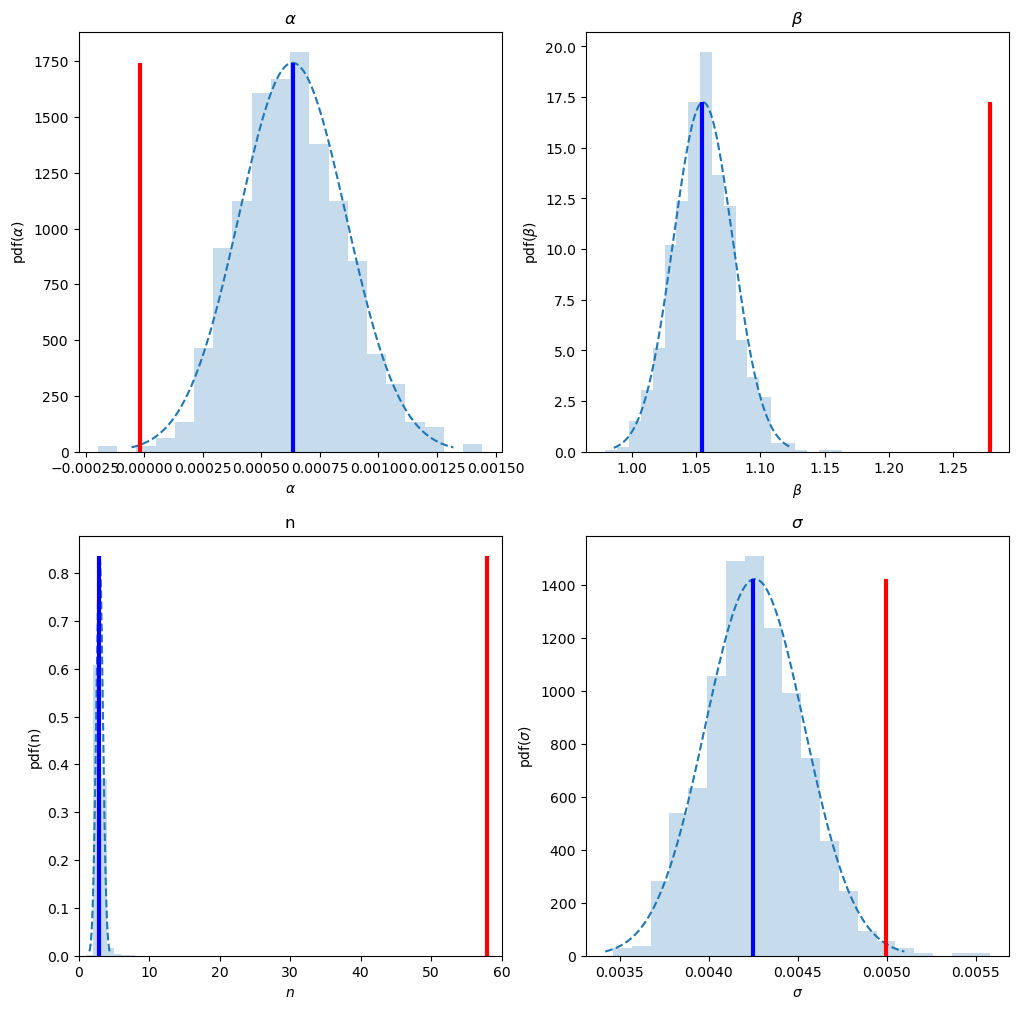

In [57]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.title(r"$\alpha$")
dist1=stats.norm(reg_alphas.mean(),reg_alphas.std())
x=np.linspace(dist1.mean()-3*dist1.std(),dist1.mean()+3*dist1.std(),201)
p=plt.plot(x,dist1.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(reg_alphas,density=True,bins=20,alpha=0.25,color=c)
plt.vlines(reg_alpha_ML,0,np.max(dist1.pdf(x)),color="blue",linewidth=3)
plt.vlines(alpha_test,0,np.max(dist1.pdf(x)),color="red",linewidth=3)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"pdf($\alpha$)")

plt.subplot(222)
plt.title(r"$\beta$")
dist2=stats.norm(reg_betas.mean(),reg_betas.std())
x=np.linspace(dist2.mean()-3*dist2.std(),dist2.mean()+3*dist2.std(),201)
p=plt.plot(x,dist2.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(reg_betas,density=True,bins=20,alpha=0.25,color=c)
plt.vlines(reg_beta_ML,0,np.max(dist2.pdf(x)),color="blue",linewidth=3)
plt.vlines(beta_test,0,np.max(dist2.pdf(x)),color="red",linewidth=3)
plt.xlabel(r"$\beta$")
plt.ylabel(r"pdf($\beta$)")

plt.subplot(223)
plt.title(r"n")
dist2=stats.norm(reg_ns.mean(),reg_ns.std())
x=np.linspace(dist2.mean()-3*dist2.std(),dist2.mean()+3*dist2.std(),201)
p=plt.plot(x,dist2.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(reg_ns,density=True,bins=np.arange(25),alpha=0.25,color=c)
plt.vlines(reg_n_ML,0,np.max(dist2.pdf(x)),color="blue",linewidth=3)
plt.vlines(n_test,0,np.max(dist2.pdf(x)),color="red",linewidth=3)
plt.xlabel(r"$n$")
plt.ylabel(r"pdf(n)")
plt.xlim(0,60)

plt.subplot(224)
plt.title(r"$\sigma$")
dist3=stats.norm(reg_sigmas.mean(),reg_sigmas.std())
x=np.linspace(dist3.mean()-3*dist3.std(),dist3.mean()+3*dist3.std(),201)
p=plt.plot(x,dist3.pdf(x),linestyle="dashed")
c=p[0].get_color()
plt.hist(reg_sigmas,density=True,bins=20,alpha=0.25,color=c)
plt.vlines(reg_sigma_ML,0,np.max(dist3.pdf(x)),color="blue",linewidth=3)
plt.vlines(sigma_test,0,np.max(dist3.pdf(x)),color="red",linewidth=3)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"pdf($\sigma$)")


### Problem 6.3

Are  the maximum likelihood estimates obtained in the test period consisted with the expected distribution generated from the training data?

Can you explain why?

#### Explanation

The bootstrap distribution assumes that the data generated duing the test and training period are drawn from <b> the same probability distribution </b>.

Because of the COVID-10  crisis  the behavior of the markets in the training period 2018-2020  and the testing period (2020-2022)
was very differen.

When working with financial data, this assumption of the future been distributed like the pass is always problematic.

Any confidence interval estimated using statistical theories must, therefore, be interpreted with caution.
    
</div>